In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Обработка данных, графики (EDA)

In [ ]:
# Просматриваю какие столбцы в тест данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


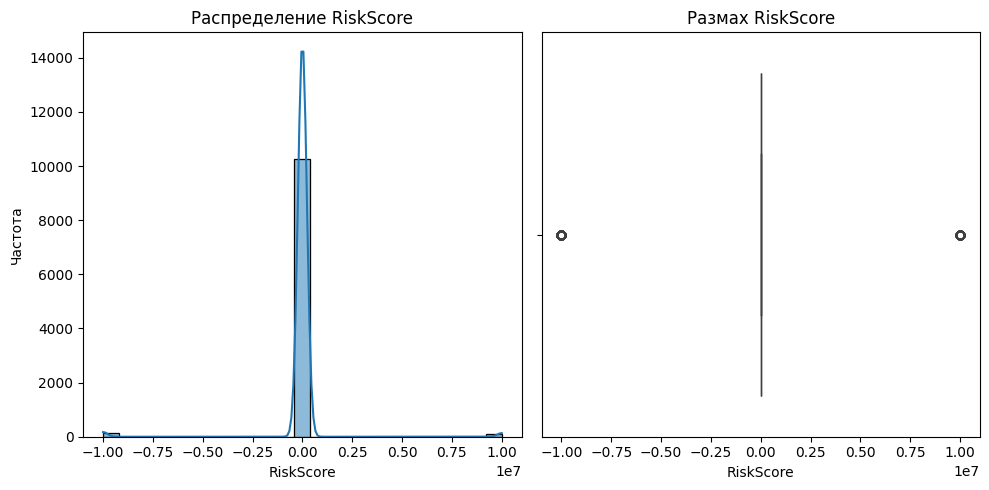

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['RiskScore'], kde=True, bins=25)
plt.title('Распределение RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['RiskScore'])
plt.title('Размах RiskScore')

plt.tight_layout()
plt.show()

In [ ]:
train_df[train_df['RiskScore'] > 100]['RiskScore'].sort_values()

,RiskScore
237,10000000.0
398,10000000.0
657,10000000.0
1168,10000000.0
1253,10000000.0
...,...
9791,10000000.0
9929,10000000.0
10586,10000000.0
10601,10000000.0


In [ ]:
train_df[train_df['RiskScore'] < 0]['RiskScore'].sort_values()

,RiskScore
33,-9999999.0
56,-9999999.0
83,-9999999.0
183,-9999999.0
198,-9999999.0
...,...
9148,-9999999.0
9263,-9999999.0
9710,-9999999.0
9959,-9999999.0


Основные значения RiskScore находятся в диапозоне от 0 до 100, найденные выбросы будем считать "мусором". Так же проверим, есть ли null значения.

In [ ]:
null_count = train_df['RiskScore'].isnull().sum()
print(f"Количество пропусков в 'RiskScore': {null_count}")
all_rows = train_df['RiskScore'].notnull().sum
print(f"Доля пропусков: {null_count / len(train_df):.2%}")

Количество пропусков в 'RiskScore': 530
Доля пропусков: 4.81%


Можем пренебречь 4.81% и удалить такие строки + удалим "мусор".

In [ ]:
initial_count = len(train_df)
train_df = train_df[(train_df['RiskScore'] >= 0) & (train_df['RiskScore'] <= 100)]

train_df = train_df.dropna(subset=['RiskScore'])

print("\nАнализ пропусков по всем признакам:")
null_analysis = pd.DataFrame({
    'Количество null': train_df.isnull().sum(),
    'Процент null': (train_df.isnull().mean() * 100).round(2)
}).sort_values('Количество null', ascending=False)


null_analysis.style.format({'Процент null': '{:.2f}%'})


Анализ пропусков по всем признакам:


,Количество null,Процент null
CreditScore,485,4.72%
BankruptcyHistory,485,4.72%
MonthlyDebtPayments,485,4.72%
LoanAmount,485,4.72%
NetWorth,485,4.72%
BaseInterestRate,485,4.72%
TotalAssets,485,4.72%
LoanPurpose,485,4.72%
CheckingAccountBalance,485,4.72%
AnnualIncome,0,0.00%


Теперь RiskScore не имеет пустых значений, перепроверим графики, что убедиться, что размах нормализовался.

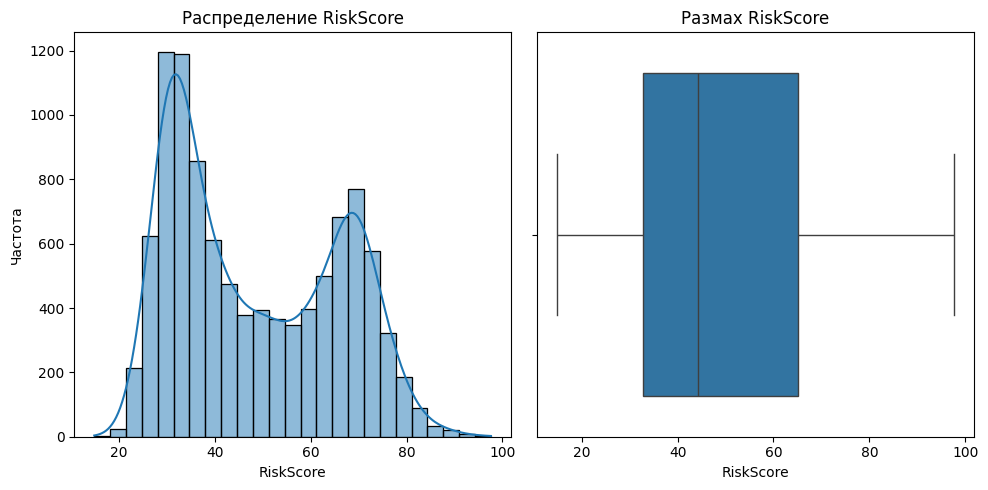

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['RiskScore'], kde=True, bins=25)
plt.title('Распределение RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['RiskScore'])
plt.title('Размах RiskScore')

plt.tight_layout()
plt.show()

Теперь остальные столбцы с пустыми значениями дополним средним. Для начала разобьём их на категории (числовые и категориальные)

In [ ]:
numeric_features = train_df.drop(columns=['RiskScore']).select_dtypes(np.number).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
Категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


In [ ]:
# Заполнение средним по столбцу для числовых
train_df[numeric_features] = train_df[numeric_features].fillna(
    train_df[numeric_features].mean()
)
# Модальное заполнение для категориальных
for feat in categorical_features:
    train_df[feat] = train_df[feat].fillna(
        train_df[feat].mode()[0]
    )
initial_rows = len(train_df)
train_df = train_df.drop_duplicates()
print(f"Удалено дубликатов в train_df: {initial_rows - len(train_df)}")

Удалено дубликатов в train_df: 484


In [ ]:
print("Пропуски в train_df:")
train_df.isnull().sum()

Пропуски в train_df:


,0
ApplicationDate,0
Age,0
AnnualIncome,0
CreditScore,0
LoanAmount,0
LoanDuration,0
MaritalStatus,0
NumberOfDependents,0
HomeOwnershipStatus,0
MonthlyDebtPayments,0


Продолжая подготовку данных, переведём наши категориальные признаки в числовые. Для начала посмотрим сколько уникальных значений, у категориальных признаков.

In [ ]:
train_df[categorical_features].nunique()

,0
ApplicationDate,9788
MaritalStatus,4
HomeOwnershipStatus,4
LoanPurpose,5
EmploymentStatus,3
EducationLevel,5


У ApplicationDate, очень много уникальных значений, разобьём её на год, месяц, день. То есть вместо 1 категориального, получим 3 числовых.

In [ ]:
train_df['ApplicationDate'] = pd.to_datetime(train_df['ApplicationDate'])

train_df['Application_Year'] = train_df['ApplicationDate'].dt.year
train_df['Application_Month'] = train_df['ApplicationDate'].dt.month
train_df['Application_Day'] = train_df['ApplicationDate'].dt.day

train_df = train_df.drop(columns=['ApplicationDate'])


<ipython-input-254-314713893897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['ApplicationDate'] = pd.to_datetime(train_df['ApplicationDate'])
<ipython-input-254-314713893897>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Application_Year'] = train_df['ApplicationDate'].dt.year
<ipython-input-254-314713893897>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [ ]:
test_df['ApplicationDate'] = pd.to_datetime(test_df['ApplicationDate'])

test_df['Application_Year'] = test_df['ApplicationDate'].dt.year
test_df['Application_Month'] = test_df['ApplicationDate'].dt.month
test_df['Application_Day'] = test_df['ApplicationDate'].dt.day

test_df = test_df.drop(columns=['ApplicationDate'])

In [ ]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']

for col in categorical_cols:
    unique_values = train_df[col].unique()
    print(f"\n{col}")
    print(f"Уникальные значения ({unique_values}")


MaritalStatus
Уникальные значения (['Divorced' 'Widowed' 'Married' 'Single']

HomeOwnershipStatus
Уникальные значения (['Rent' 'Mortgage' 'Other' 'Own']

LoanPurpose
Уникальные значения (['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']

EmploymentStatus
Уникальные значения (['Employed' 'Self-Employed' 'Unemployed']

EducationLevel
Уникальные значения (['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


Признаки номинальные (не имеют никакого порядка по значениям). Значит можно применить метод One-hot-encoding.

In [ ]:
def one_hot_encoding(df, categorical_cols):
    temp = df.copy()
    dummies = pd.get_dummies(temp[categorical_cols],
                              prefix=categorical_cols,
                             dtype='int8')

    result = pd.concat([temp.drop(columns=categorical_cols), dummies], axis=1)
    return result

In [ ]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose',
                   'EmploymentStatus', 'EducationLevel']

train_df = one_hot_encoding(train_df, categorical_cols)
test_df = one_hot_encoding(test_df, categorical_cols)

train_df.head()


,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,LoanPurpose_Home,LoanPurpose_Other,EmploymentStatus_Employed,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,EducationLevel_Associate,EducationLevel_Bachelor,EducationLevel_Doctorate,EducationLevel_High School,EducationLevel_Master
0,27.0,66829.0,549.0,17290.0,60.0,1.0,1095.0,0.151985,2.0,1.0,...,0,0,1,0,0,1,0,0,0,0
1,55.0,172147.0,850.0,16110.0,36.0,1.0,211.0,0.175693,3.0,0.0,...,1,0,1,0,0,0,0,0,1,0
2,51.0,300000.0,850.0,38436.0,36.0,0.0,546.0,0.444605,3.0,0.0,...,0,0,1,0,0,0,1,0,0,0
3,25.0,34683.0,847.0,19186.0,48.0,0.0,153.0,0.188452,7.0,0.0,...,0,0,1,0,0,0,0,0,1,0
4,55.0,300000.0,850.0,30437.0,48.0,2.0,562.0,0.273431,3.0,1.0,...,0,0,1,0,0,0,1,0,0,0


Теперь все признаки в наших даннах числовые.

# Графики зависимостей признаков от частоты

In [ ]:
def plot_distribution(df, column_name, bins=25, figsize=(10, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True, bins=bins)
    plt.title(f'Распределение {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'Размах {column_name}')
    plt.xlabel(column_name)

    plt.tight_layout()
    plt.show()

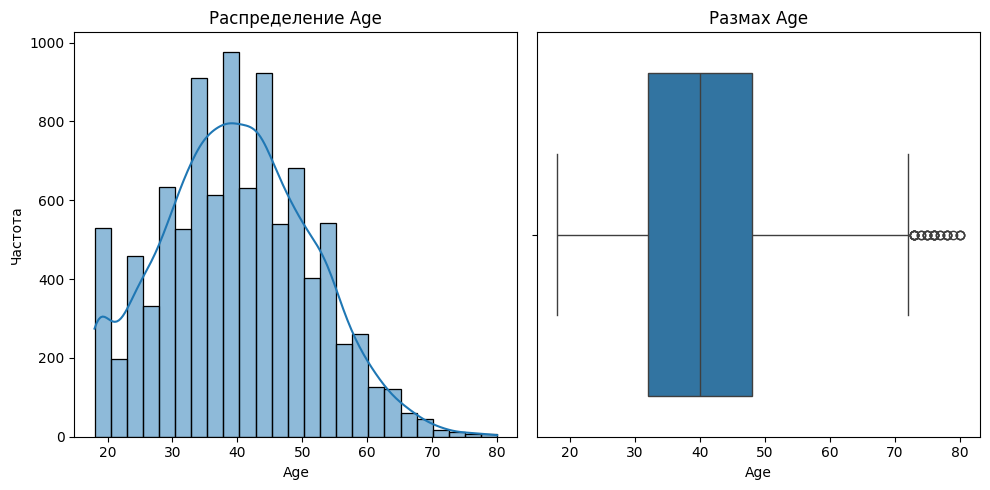

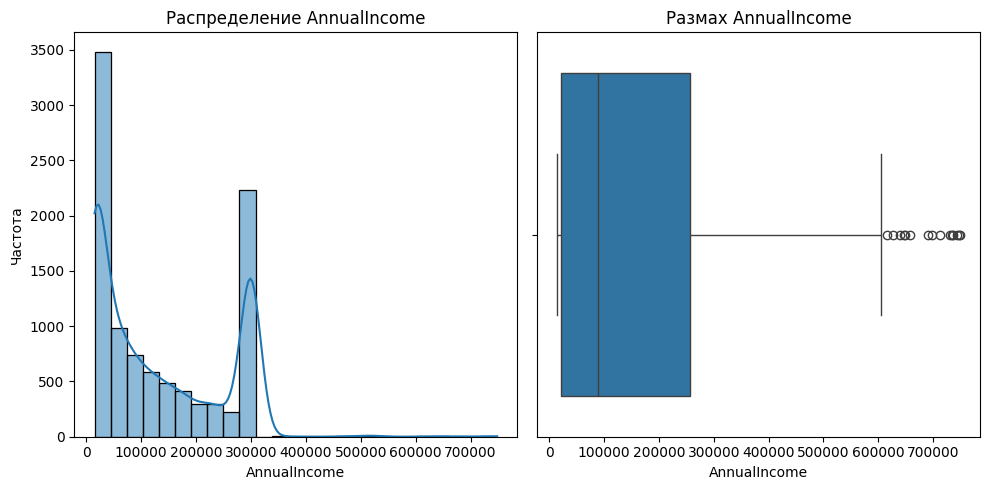

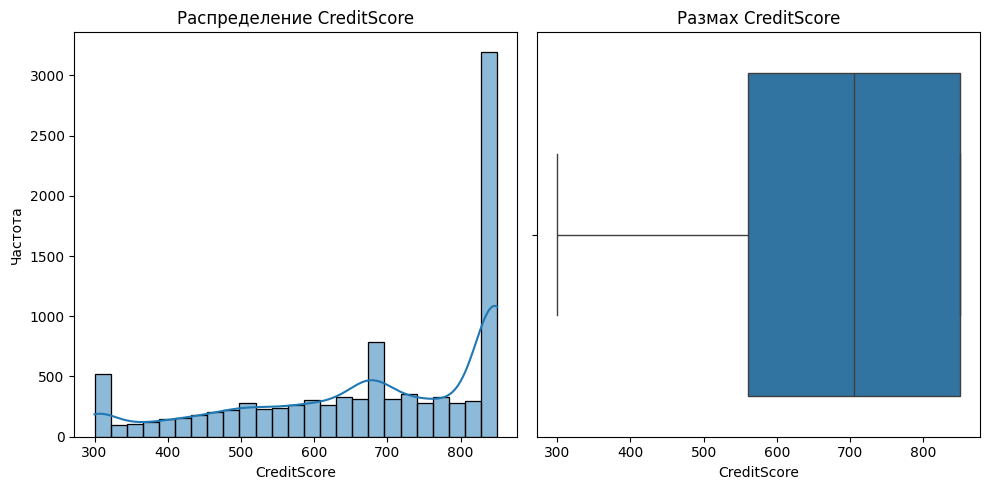

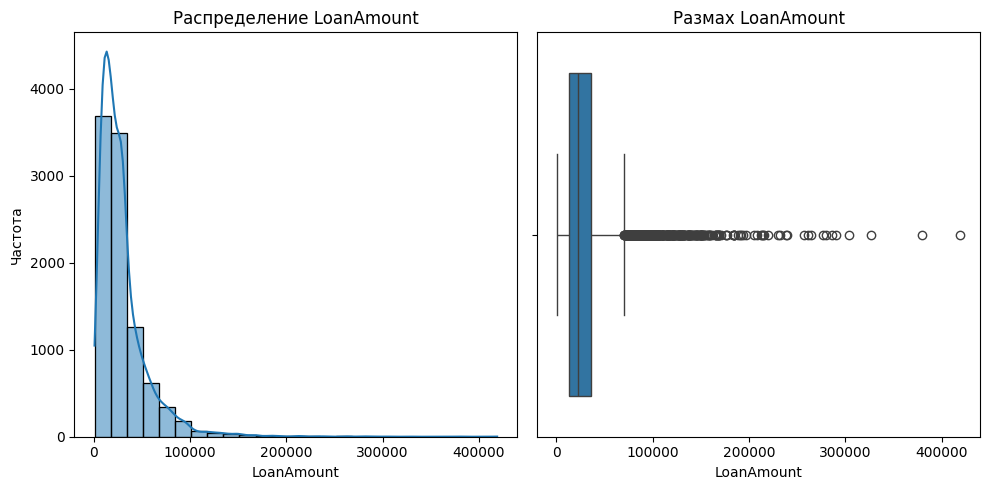

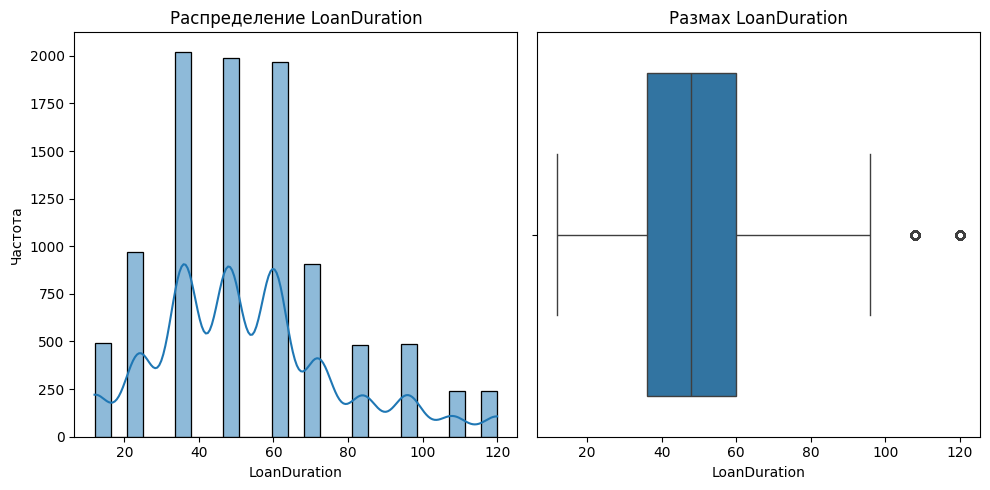

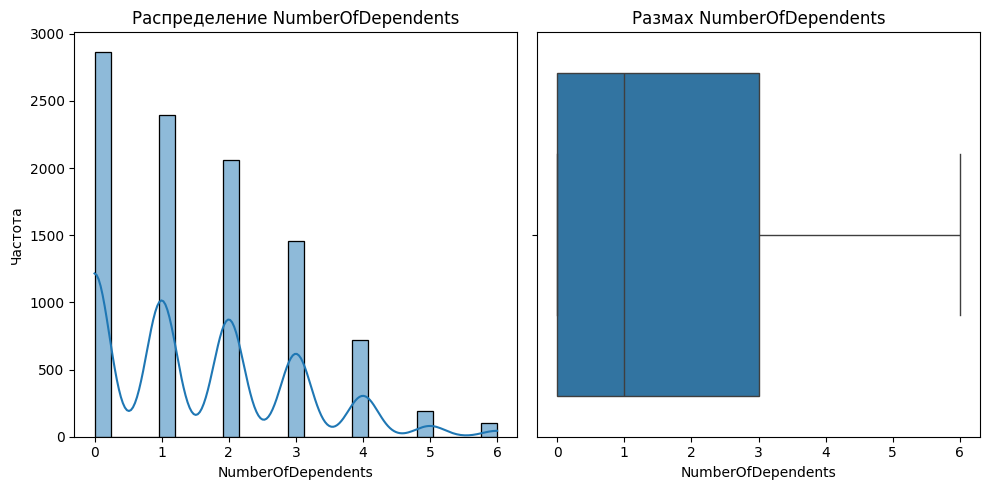

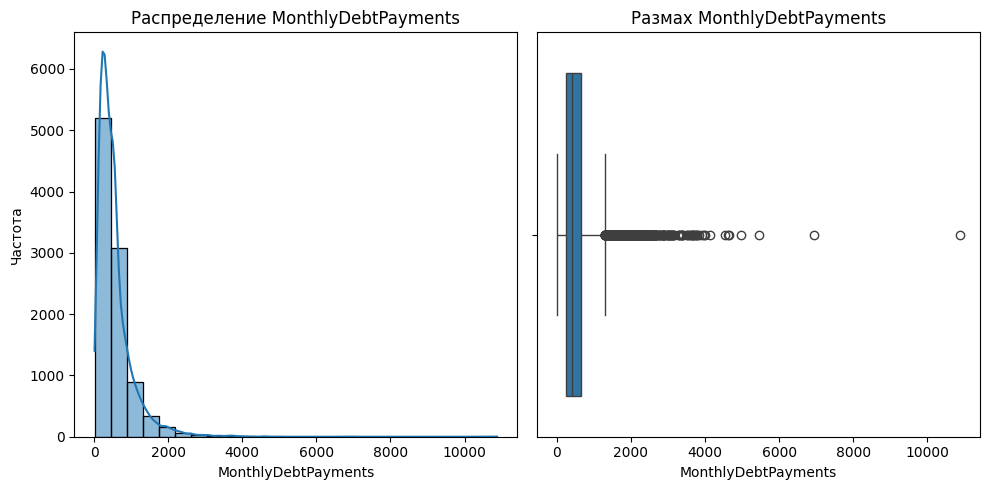

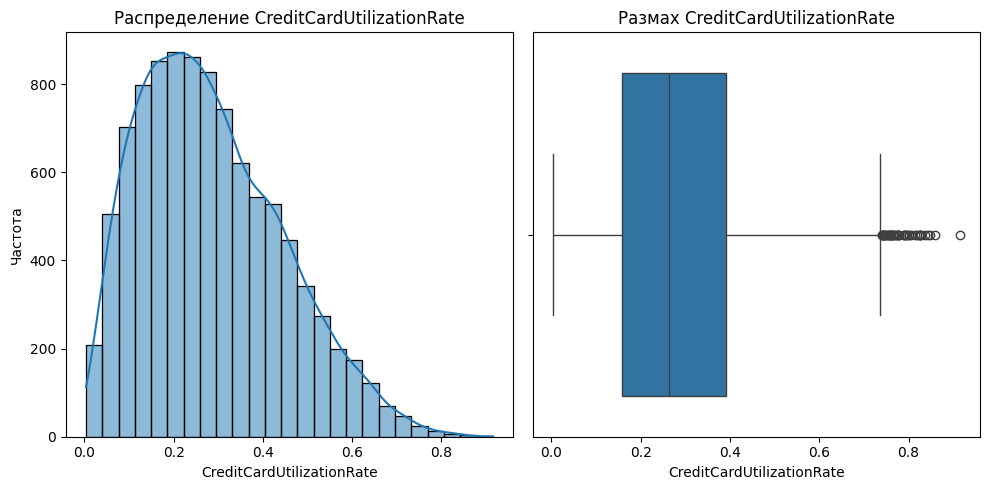

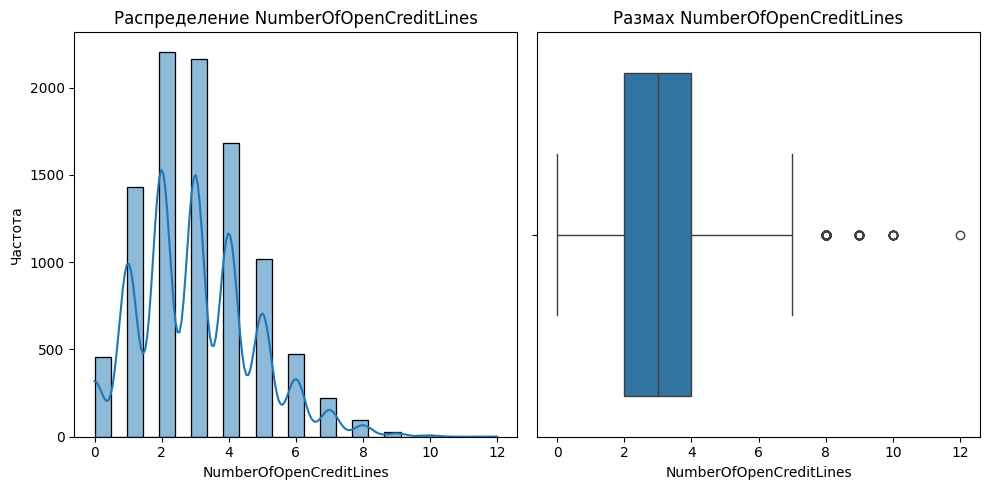

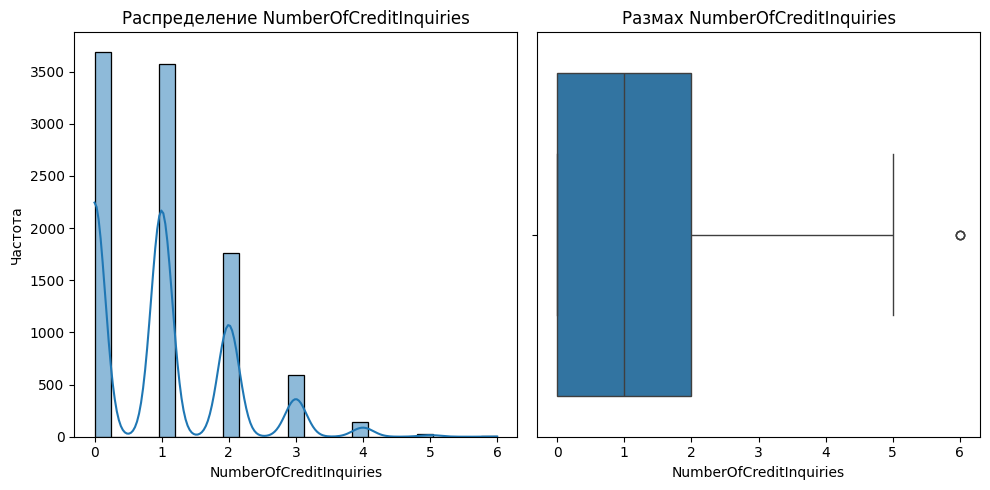

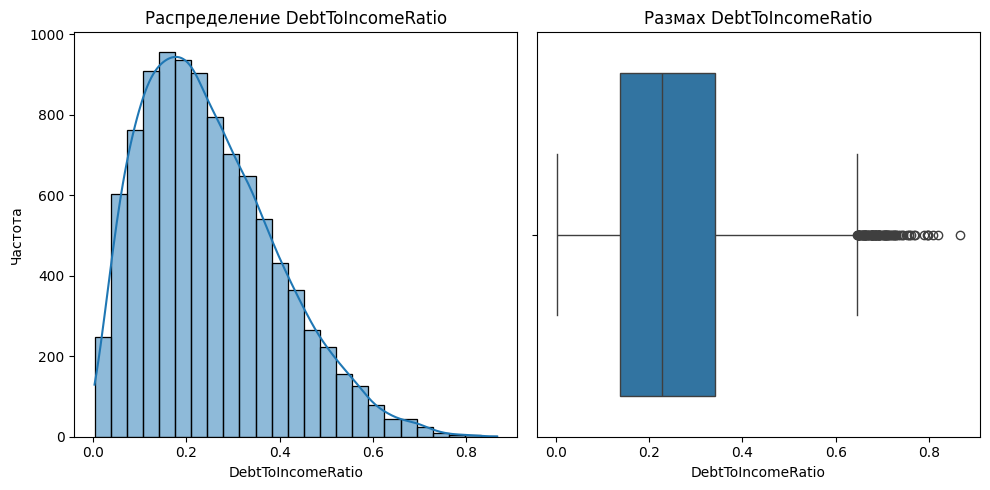

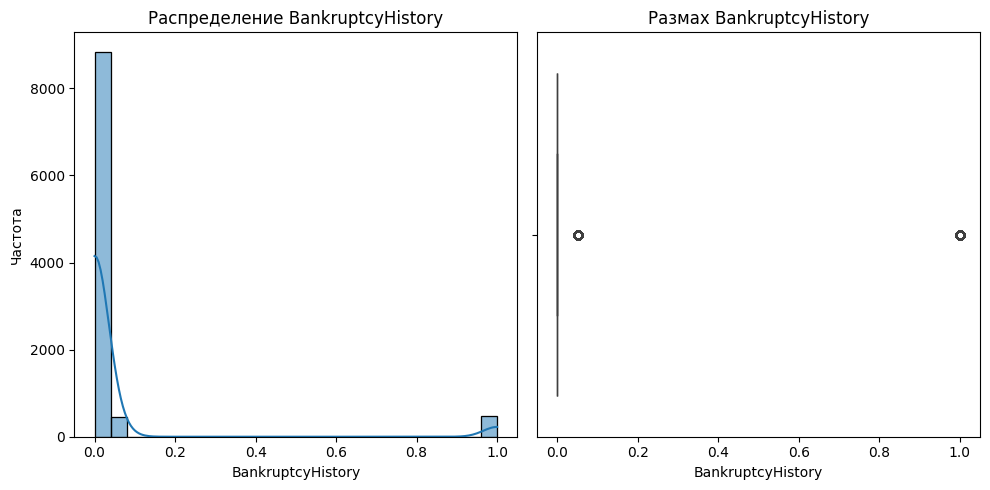

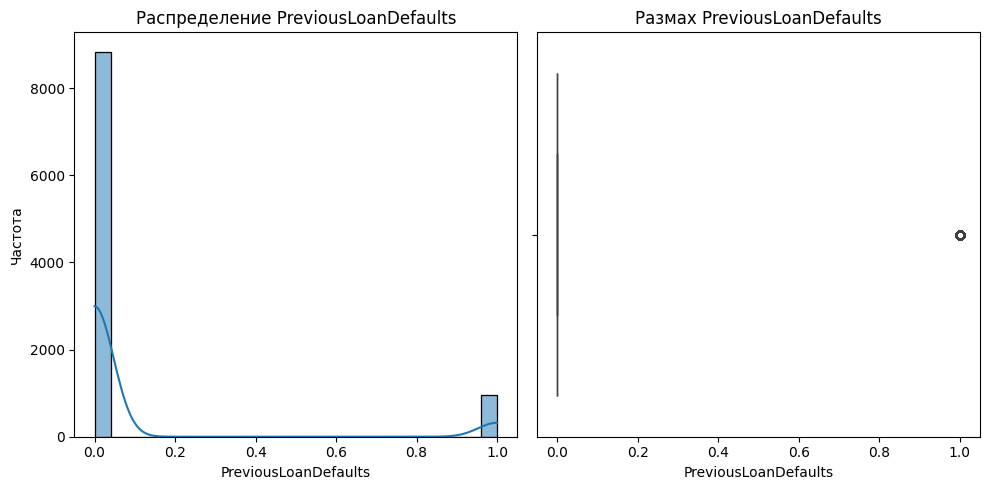

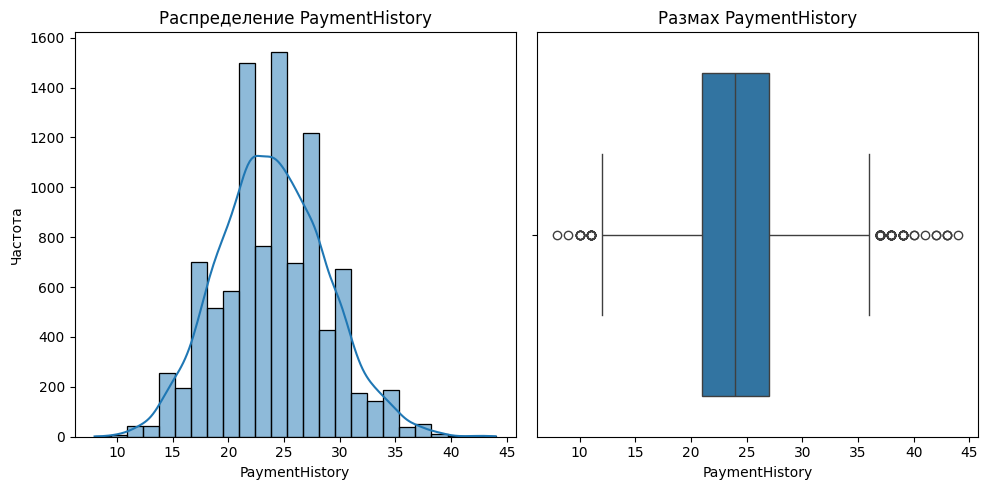

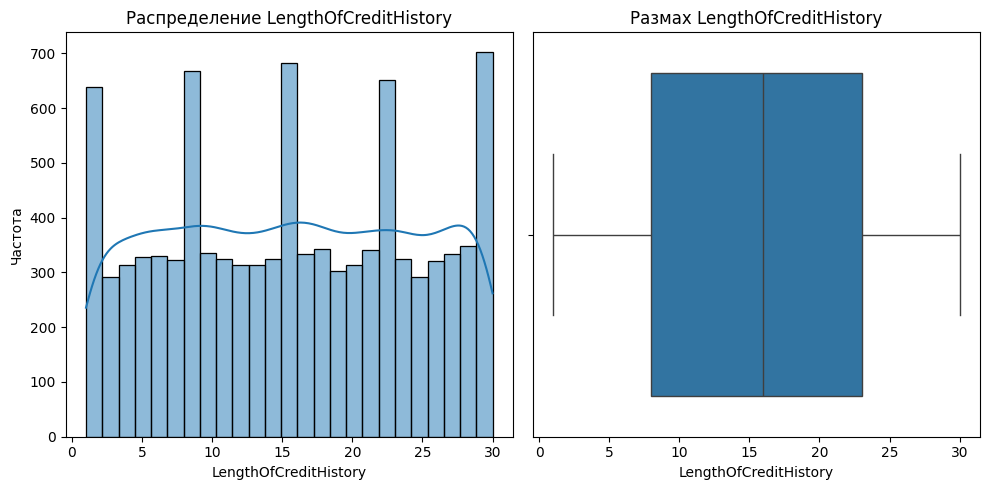

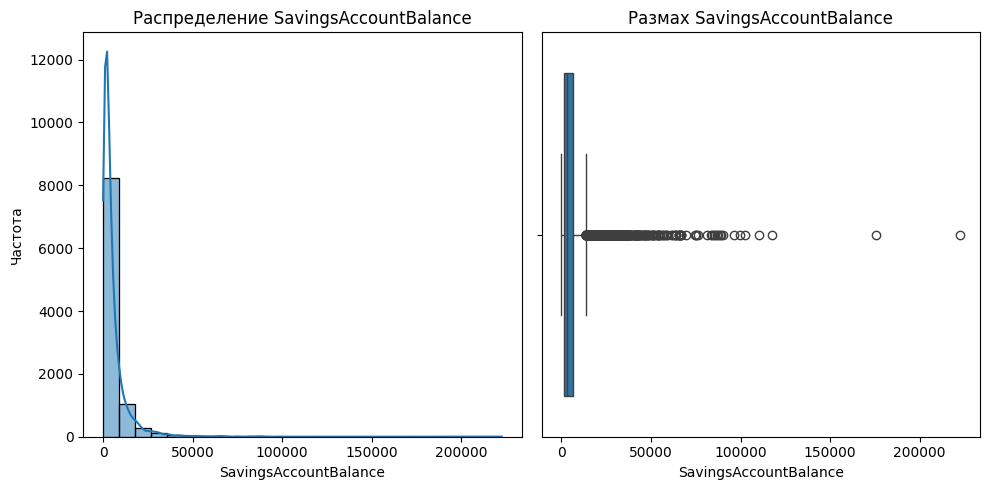

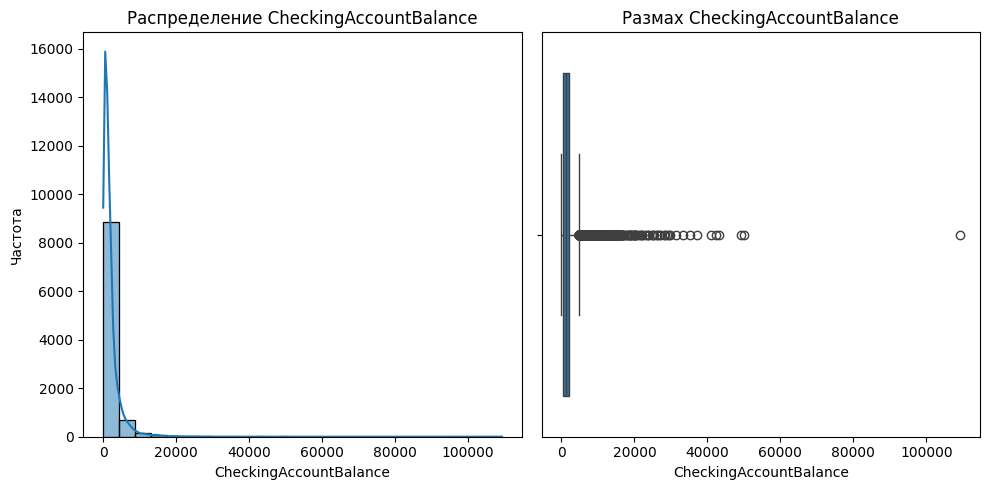

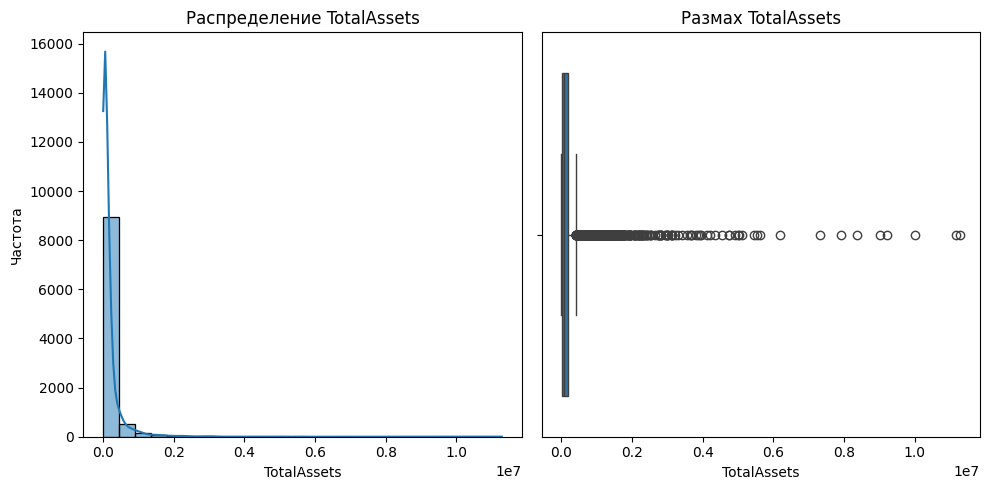

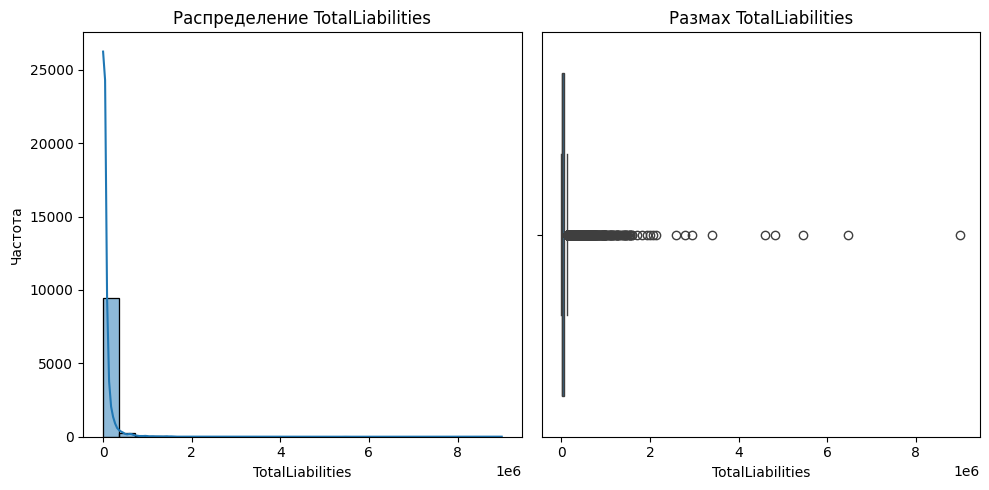

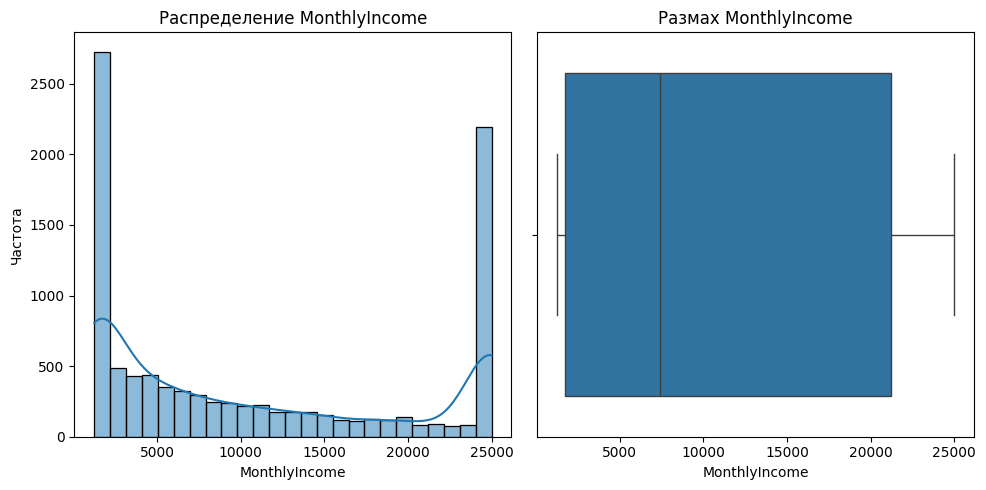

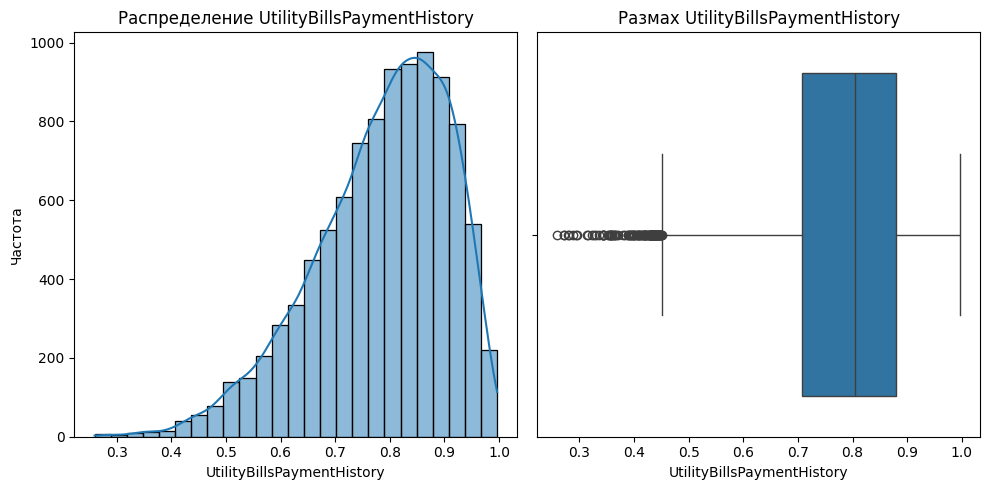

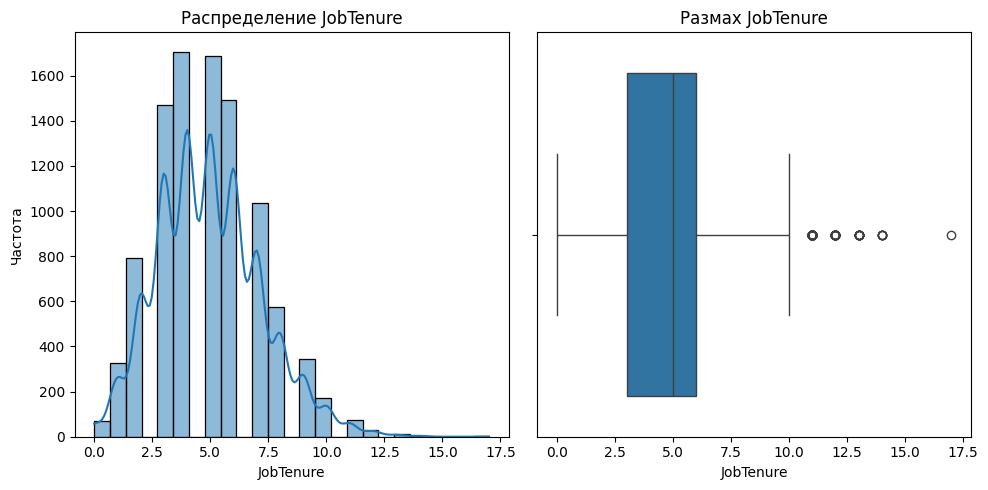

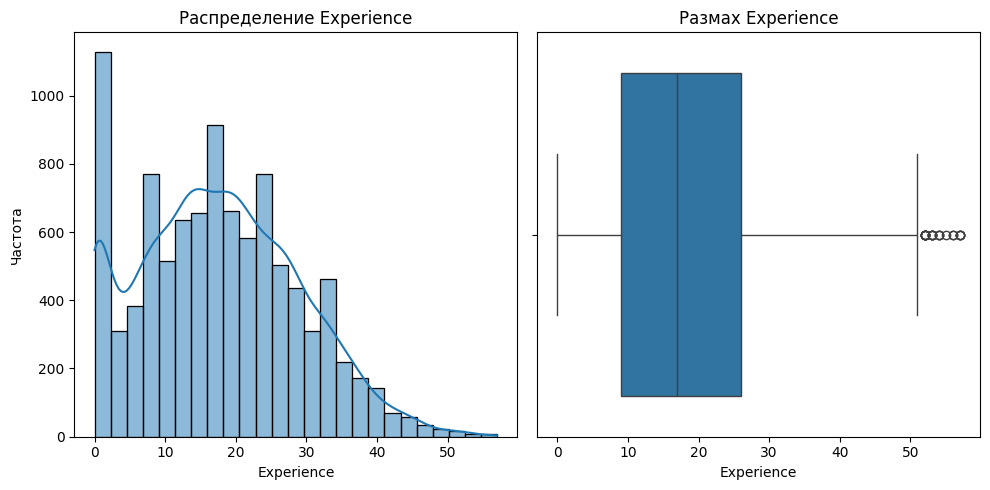

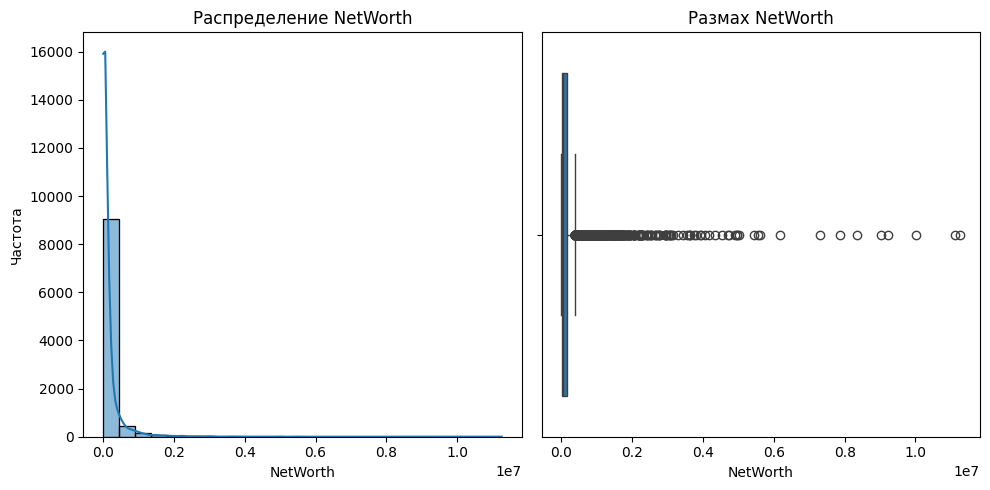

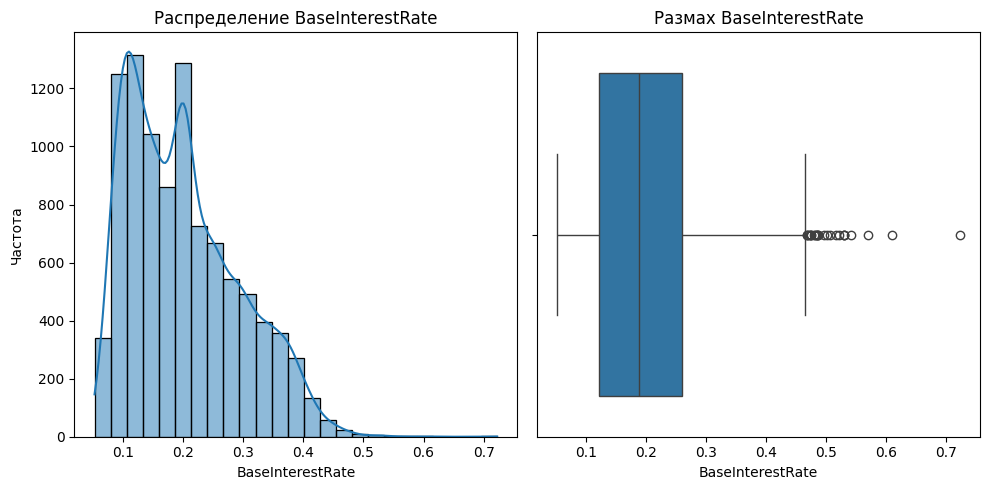

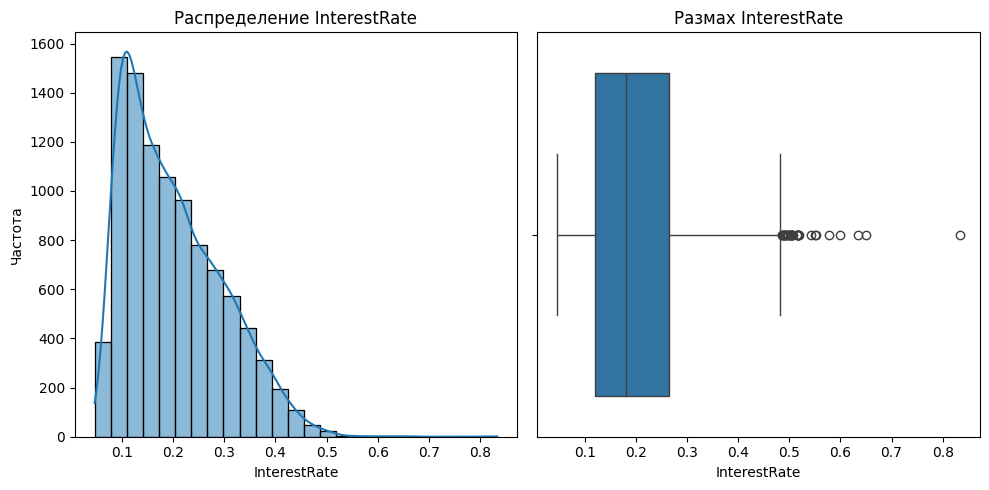

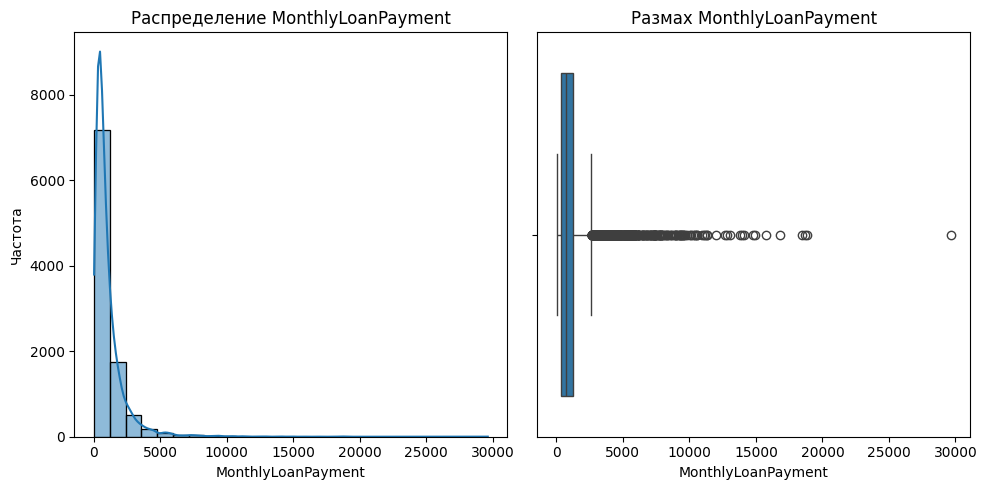

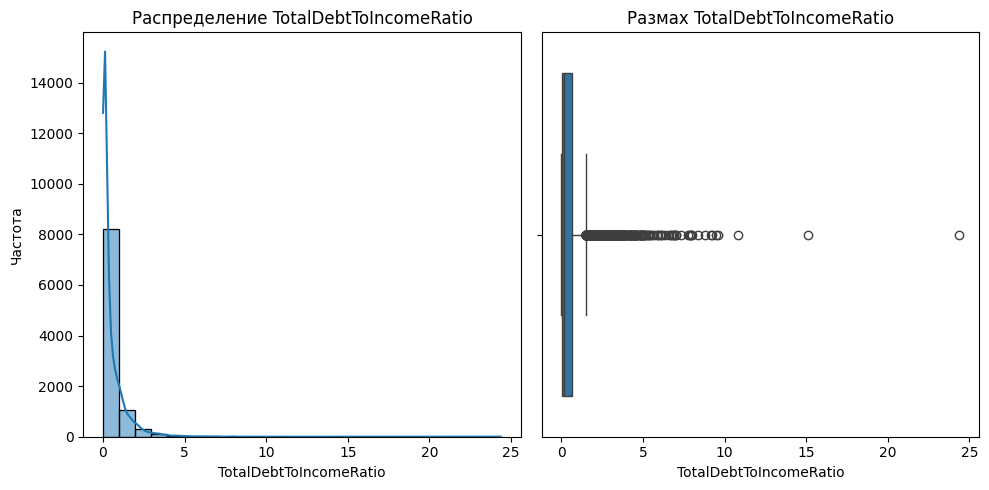

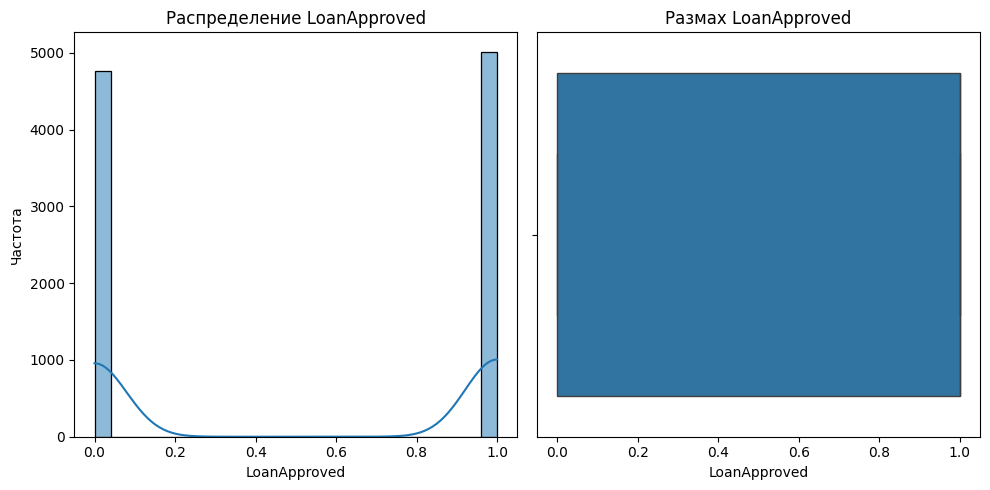

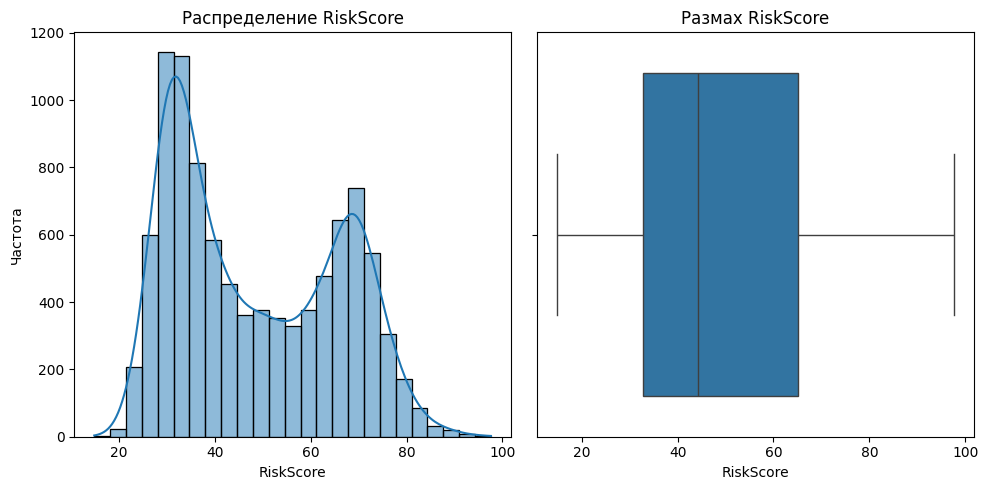

In [ ]:
numeric_features = [col for col in train_df.select_dtypes(np.number).columns
                   if '_' not in col]
for feature in numeric_features:
    plot_distribution(train_df, feature)

# Продолжение обработки данных, матрица корреляций, зависимости.

In [ ]:
copy_train_df = train_df.copy()
copy_test_df = test_df.copy()

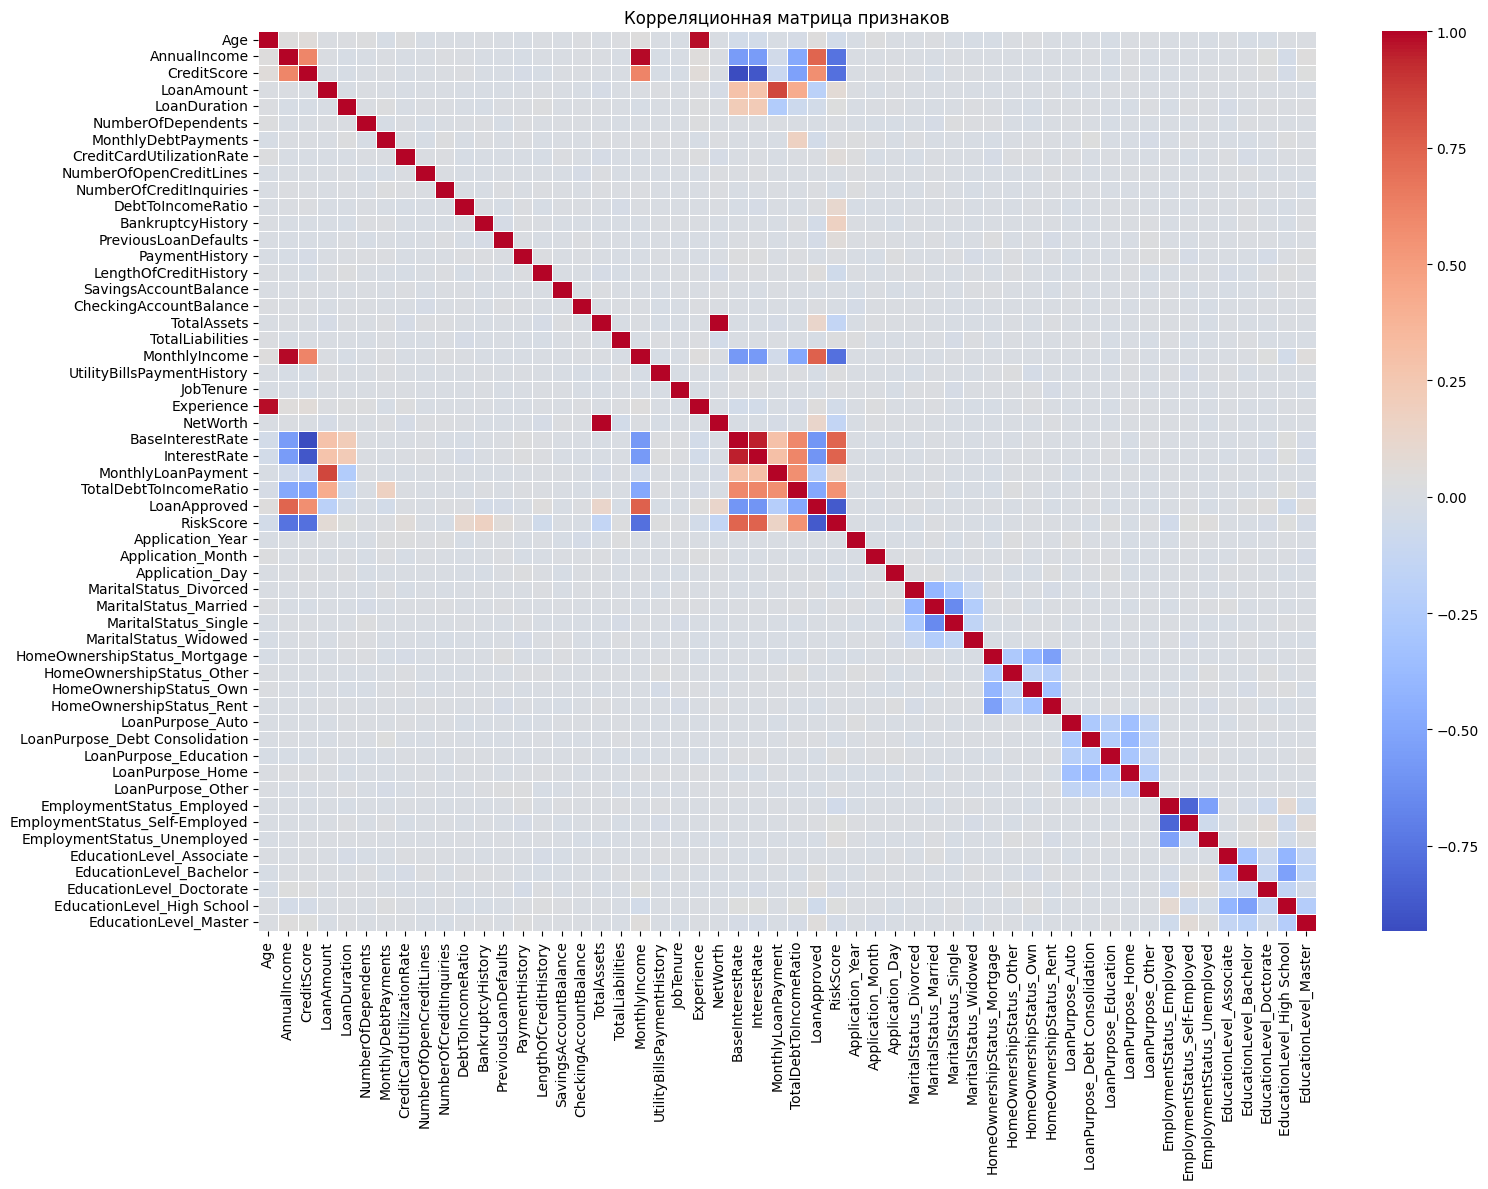

In [ ]:
corr_matrix = copy_train_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=False,
            fmt='.2f',
            linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()